# EDA

## 1. Załaduj dane

In [1]:
# Standard imports
from typing import Tuple
import time

# Third party imports
from geopy.exc import  GeocoderTimedOut, GeocoderUnavailable
from geopy.geocoders import Nominatim
from haversine import haversine
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import warnings

# Local imports
from _csv_utils import data_timeplace, DataPathCleaningManager


In [2]:

data_path_manager = DataPathCleaningManager(data_timeplace)
combined_df = data_path_manager._load_cleaned_df(domain="combined")

In [3]:
import pandas as pd

def rename_columns(df: pd.DataFrame, translations: dict) -> pd.DataFrame:
    """
    Rename columns in a DataFrame with a MultiIndex according to provided translations.

    Args:
    df (pd.DataFrame): The DataFrame whose columns are to be renamed.
    translations (dict): A dictionary mapping the old column names (as tuples) to the new ones.

    Returns:
    pd.DataFrame: A new DataFrame with columns renamed.
    """
    
    # Create a new MultiIndex with the translated column names
    new_columns = []
    for col in df.columns:
        # Translate the column if it is in the translations, else keep the original
        new_col = translations.get(col, col)
        new_columns.append(new_col)

    new_index = pd.MultiIndex.from_tuples(new_columns)
    
    # Assign the new MultiIndex to the DataFrame and return it
    df.columns = new_index
    return df

# Dictionary of translations provided
columns_translation = {
    ('listing', 'link'): ('ogłoszenie', 'link'),
    ('listing', 'title'): ('ogłoszenie', 'tytuł'),
    ('listing', 'summary_description'): ('ogłoszenie', 'krótki_opis'),
    ('listing', 'remote_service'): ('ogłoszenie', 'usługa_zdalna'),
    ('pricing', 'price'): ('wycena', 'cena'),
    ('pricing', 'rent'): ('wycena', 'czynsz'),
    ('pricing', 'total_rent'): ('wycena', 'czynsz_całkowity'),
    ('pricing', 'total_rent_sqm'): ('wycena', 'czynsz_za_metr'),
    ('pricing', 'deposit'): ('wycena', 'kaucja'),
    ('pricing', 'deposit_ratio'): ('wycena', 'proporcja_kaucji'),
    ('location', 'complete_address'): ('lokalizacja', 'pełny_adres'),
    ('location', 'street'): ('lokalizacja', 'ulica'),
    ('location', 'city'): ('lokalizacja', 'miasto'),
    ('location', 'voivodeship'): ('lokalizacja', 'województwo'),
    ('size', 'square_meters'): ('wielkość', 'metry_kwadratowe'),
    ('size', 'number_of_rooms'): ('wielkość', 'liczba_pokoi'),
    ('size', 'floor'): ('wielkość', 'piętro'),
    ('size', 'attic'): ('wielkość', 'strych'),
    ('size', 'building_floors'): ('wielkość', 'liczba_pięter_budynku'),
    ('legal_and_availability', 'available_from'): ('własność_i_dostępność', 'dostępne_od'),
    ('legal_and_availability', 'completion'): ('własność_i_dostępność', 'zakończenie_budowy'),
    ('legal_and_availability', 'ownership'): ('własność_i_dostępność', 'własność'),
    ('legal_and_availability', 'rent_to_students'): ('własność_i_dostępność', 'wynajem_dla_studentów'),
    ('type_and_year', 'building_type'): ('rodzaj_i_rocznik', 'typ_budynku'),
    ('type_and_year', 'build_year'): ('rodzaj_i_rocznik', 'rok_budowy'),
    ('amenities', 'elevator'): ('udogodnienia', 'winda'),
    ('amenities', 'parking_space'): ('udogodnienia', 'miejsce_parkingowe'),
    ('equipment', 'no_information'): ('wyposażenie', 'brak_informacji'),
    ('equipment', 'stove'): ('wyposażenie', 'kuchenka'),
    ('equipment', 'fridge'): ('wyposażenie', 'lodówka'),
    ('equipment', 'furniture'): ('wyposażenie', 'meble'),
    ('equipment', 'oven'): ('wyposażenie', 'piekarnik'),
    ('equipment', 'washing_machine'): ('wyposażenie', 'pralka'),
    ('equipment', 'TV'): ('wyposażenie', 'telewizor'),
    ('equipment', 'dishwasher'): ('wyposażenie', 'zmywarka'),
    ('media_types', 'no_information'): ('typy_mediów', 'brak_informacji'),
    ('media_types', 'internet'): ('media_komunikacyjne', 'internet'),
    ('media_types', 'telephone'): ('media_komunikacyjne', 'telefon'),
    ('media_types', 'cable_TV'): ('media_komunikacyjne', 'telewizja_kablowa'),
    ('heating', 'no_information'): ('ogrzewanie', 'brak_informacji'),
    ('heating', 'electric'): ('ogrzewanie', 'elektryczne'),
    ('heating', 'gas'): ('ogrzewanie', 'gazowe'),
    ('heating', 'other'): ('ogrzewanie', 'inne'),
    ('heating', 'boiler_room'): ('ogrzewanie', 'kotłownia'),
    ('heating', 'district'): ('ogrzewanie', 'miejskie'),
    ('heating', 'tile_stove'): ('ogrzewanie', 'piec_kaflowy'),
    ('security', 'no_information'): ('bezpieczeństwo', 'brak_informacji'),
    ('security', 'intercom_or_video_intercom'): ('bezpieczeństwo', 'domofon_lub_wideodomofon'),
    ('security', 'anti_burglary_doors_or_windows'): ('bezpieczeństwo', 'drzwi_lub_okna_antywłamaniowe'),
    ('security', 'monitoring_or_security'): ('bezpieczeństwo', 'monitoring_lub_ochrona'),
    ('security', 'anti_burglary_roller_blinds'): ('bezpieczeństwo', 'rolety_antywłamaniowe'),
    ('security', 'alarm_system'): ('bezpieczeństwo', 'system_alarmowy'),
    ('security', 'enclosed_area'): ('bezpieczeństwo', 'teren_ogrodzony'),
    ('windows', 'aluminum'): ('okna', 'aluminiowe'),
    ('windows', 'no_information'): ('okna', 'brak_informacji'),
    ('windows', 'wooden'): ('okna', 'drewniane'),
    ('windows', 'plastic'): ('okna', 'plastikowe'),
    ('building_material', 'concrete'): ('materiał_budowlany', 'beton'),
    ('building_material', 'aerated_concrete'): ('materiał_budowlany', 'beton_komórkowy'),
    ('building_material', 'no_information'): ('materiał_budowlany', 'brak_informacji'),
    ('building_material', 'brick'): ('materiał_budowlany', 'cegła'),
    ('building_material', 'wood'): ('materiał_budowlany', 'drewno'),
    ('building_material', 'other'): ('materiał_budowlany', 'inny'),
    ('building_material', 'lightweight_aggregate'): ('materiał_budowlany', 'keramzyt'),
    ('building_material', 'hollow_brick'): ('materiał_budowlany', 'pustak'),
    ('building_material', 'silicate'): ('materiał_budowlany', 'silikat'),
    ('building_material', 'large_panel'): ('materiał_budowlany', 'wielka_płyta'),
    ('building_material', 'reinforced_concrete'): ('materiał_budowlany', 'żelbet'),
    ('additional_information', 'no_information'): ('informacje_dodatkowe', 'brak_informacji'),
    ('additional_information', 'duplex'): ('informacje_dodatkowe', 'mieszkanie_dwupoziomowe'),
    ('additional_information', 'air_conditioning'): ('informacje_dodatkowe', 'klimatyzacja'),
    ('additional_information', 'separate_kitchen'): ('informacje_dodatkowe', 'oddzielna_kuchnia'),
    ('additional_information', 'basement'): ('informacje_dodatkowe', 'piwnica'),
    ('additional_information', 'utility_room'): ('informacje_dodatkowe', 'pomieszczenie_gospodarcze'),
    ('additional_information', 'non_smokers_only'): ('informacje_dodatkowe', 'tylko_dla_niepalących'),
}

combined_df = rename_columns(combined_df, columns_translation)

## 2. Badania eksploracyjne

### 2.1 Dane numeryczne

In [4]:
combined_df.describe().rename(index={'count': 'liczba', 'mean': 'średnia', 'std': 'odchylenie standardowe'})

wycena                               \
                                cena      czynsz czynsz_całkowity   
liczba                   1106.000000  593.000000      1106.000000   
średnia                  2180.465642  463.910624      2429.198915   
odchylenie standardowe   1429.766366  252.601285      1442.413882   
min                       500.000000    1.000000       500.000000   
25%                      1500.000000  300.000000      1687.000000   
50%                      1900.000000  500.000000      2200.000000   
75%                      2500.000000  650.000000      2800.000000   
max                     19000.000000  990.000000     19001.000000   

                                                                      \
                       czynsz_za_metr        kaucja proporcja_kaucji   
liczba                         1106.0    742.000000       742.000000   
średnia                     51.876078   3477.051213         1.457399   
odchylenie standardowe      18.852072   3698.524190         0.848110   
min                          2.708333      2.000000         0.000000   
25%                         38.693878   2000.000000         1.000000   
50%                         50.575658   3000.000000         1.295000   
75%                         63.447965   3800.000000         1.760000   
max                        138.888889  57000.000000        12.000000   

                               wielkość                         \
                       metry_kwadratowe liczba_pokoi    piętro   
liczba                           1106.0       1106.0    1083.0   
średnia                       49.740506     2.119349  2.757156   
odchylenie standardowe        26.233006     0.858414   2.57227   
min                                 8.0          1.0      -1.0   
25%                                36.0          2.0       1.0   
50%                                45.0          2.0       2.0   
75%                                56.0          3.0       4.0   
max                               413.0          6.0      11.0   

                                             rodzaj_i_rocznik  
                       liczba_pięter_budynku       rok_budowy  
liczba                                 979.0       476.000000  
średnia                              5.48621      1993.170168  
odchylenie standardowe              3.828449        33.635859  
min                                      1.0      1893.000000  
25%                                      3.0      1975.000000  
50%                                      4.0      2011.500000  
75%                                      7.0      2021.000000  
max                                     25.0      2025.000000

11 piętro to piętra 10+

**Podsumowanie Danych Numerycznych na Dużą Skalę:**

1. **Oferty**<br>
Znajdują się w promieniu `25km`<br>
od `"Mierzęcice, Będziński, Śląskie"`, w pobliżu regionalnego lotniska międzynarodowego.<br>
Całkowita liczba ofert wynosi `1106`.
2. **Średni Całkowity Czynsz**:<br>
Mediana całkowitego czynszu wynosi `2200,00 PLN`.
3. **Zakres Czynszu i Odchylenie Standardowe**:<br>
Całkowity czynsz waha się od minimum `500` do maksimum `19,001`, przy odchyleniu standardowym wynoszącym `1442,41`.<br>Równocześnie szeroki zakres i duże odchylenie standardowe wskazują na znaczną zmienność cen wynajmu.
4. **Rozmiar Nieruchomości:**<br>
Średni rozmiar nieruchomości to około `49,74` metrów kwadratowych.<br>Najmniejsza nieruchomość ma `8` metrów kwadratowych, a największa `413` metrów kwadratowych.
5. **Rok Budowy**:<br>
Nieruchomości w zestawieniu danych zostały zbudowane między `1893` a `2025`, przy medianie roku budowy `2011`.<br>Dane obejmują szeroki zakres wieku nieruchomości, od historycznych po nowoczesne konstrukcje.
6. **Informacje o na którym piętrze jest mieszkanie**:<br>Mediana pięter, na których znajdują się nieruchomości to `2` piętro, wśród nieruchomości mieszczącymi się od poziomu piwnicy (`-1`) do `10 i wyższych` pięter. Mediana dla semj liczby pięter w budynkach to około `4`, co sugeruje, że większość nieruchomości znajduje się w budynkach niskich lub średniowysokich.
7. **Koszt za Metr Kwadratowy**:<br>
Średni koszt za metr kwadratowy wynosi `51,88 PLN`, przy cenach wahających się od tak niskich jak `2,71 PLN` do tak wysokich jak `138,89 PLN` za metr kwadratowy.

### 2.2 Total rent

In [6]:
def advanced_statistical_analysis(df: pd.DataFrame = combined_df):
    price_data = df['wycena']['czynsz_całkowity']

    # Central Tendency Measures
    mean_price = price_data.mean()
    median_price = price_data.median()
    mode_price = price_data.mode()[0]

    # Variability Measures
    std_dev_price = price_data.std()
    variance_price = price_data.var()
    range_price = price_data.max() - price_data.min()
    iqr_price = np.percentile(price_data, 75) - np.percentile(price_data, 25)

    # Skewness and Kurtosis
    skewness_price = price_data.skew()
    kurtosis_price = price_data.kurtosis()

    # Quantile Analysis
    quantiles_price = price_data.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

    # Outlier Detection: Using the 1.5*IQR rule
    lower_bound = np.percentile(price_data, 25) - 1.5 * iqr_price
    upper_bound = np.percentile(price_data, 75) + 1.5 * iqr_price
    outliers_upper = price_data[(price_data >= upper_bound)].count()
    outliers_lower = price_data[(price_data <= lower_bound)].count()
    outlier_total = outliers_upper + outliers_lower

    advanced_statistics = {
        "Średnia": mean_price.round(2),
        "Mediana": median_price,
        "Odchylenie standardowe": std_dev_price.round(2),
        "Dominanta": mode_price,
        "Wariancja": variance_price.round(2),
        "Zakres": range_price,
        "Rozstęp międzykwartylowy (IQR)": iqr_price,
        "Skośność": skewness_price.round(2),
        "Kurtoza": kurtosis_price.round(2),
        "Kwantyle": quantiles_price,
        "Dolna granica wykrywania wartości odstających": lower_bound,
        "Górna granica wykrywania wartości odstających": upper_bound,
        "Liczba wartości poniżej dolnej granicy": outliers_upper,
        "Liczba wartości powyżej górnej granicy": outliers_lower,
        "Liczba wartości odstających": outlier_total,
        "Całkowita liczba ofert": price_data.count(),
        "Stosunek liczby wartości odstających do całkowitej liczby ofert": str((outlier_total / price_data.count()).round(2) * 100)+ "%",
    }

    print("Cena łączna, zaawansowane statystyki:")
    return advanced_statistics

advanced_statistical_analysis(combined_df)

Cena łączna, zaawansowane statystyki:


{'Średnia': 2429.2,
 'Mediana': 2200.0,
 'Odchylenie standardowe': 1442.41,
 'Dominanta': 1500.0,
 'Wariancja': 2080557.81,
 'Zakres': 18501.0,
 'Rozstęp międzykwartylowy (IQR)': 1113.0,
 'Skośność': 4.89,
 'Kurtoza': 41.71,
 'Kwantyle': 0.25    1687.0
 0.50    2200.0
 0.75    2800.0
 0.90    3557.5
 0.95    4569.5
 0.99    7270.0
 Name: czynsz_całkowity, dtype: float64,
 'Dolna granica wykrywania wartości odstających': 17.5,
 'Górna granica wykrywania wartości odstających': 4469.5,
 'Liczba wartości poniżej dolnej granicy': 67,
 'Liczba wartości powyżej górnej granicy': 0,
 'Liczba wartości odstających': 67,
 'Całkowita liczba ofert': 1106,
 'Stosunek liczby wartości odstających do całkowitej liczby ofert': '6.0%'}

**Wnioski z analizy cen wynajmu:**

1. **Tendencja cen wynajmu**:<br>
Wiele czynszów jest bardziej przystępnych cenowo, podczas gdy tylko kilka jest naprawdę drogich.

1. **Wyjątkowe ceny wynajmu**:<br>
Około `6%` cen wynajmu jest znacznie wyższych lub niższych od typowych.
Te kilka nietypowych czynszów może sprawić, że średnia będzie wyglądać na wyższą niż to, co widzi większość ludzi.

1. **Zróżnicowanie cen wynajmu**:<br>
Analizując dane dotyczące wynajmu, spektrum cen jest bardzo szerokie.<br>
Większość wynajmów `(75%)` jest w przeciętnych cenach.<br>
Jednak patrząc na ceny wyższe od przeciętnych ceny wynajmu znacząco rosną.<br>
Górne `5%` nieruchomości mają czynsze znacznie wyższe od średniej,<br>
a górne `1%` znajdują się w jeszcze bardziej ekskluzywnym przedziale cenowym.<br>


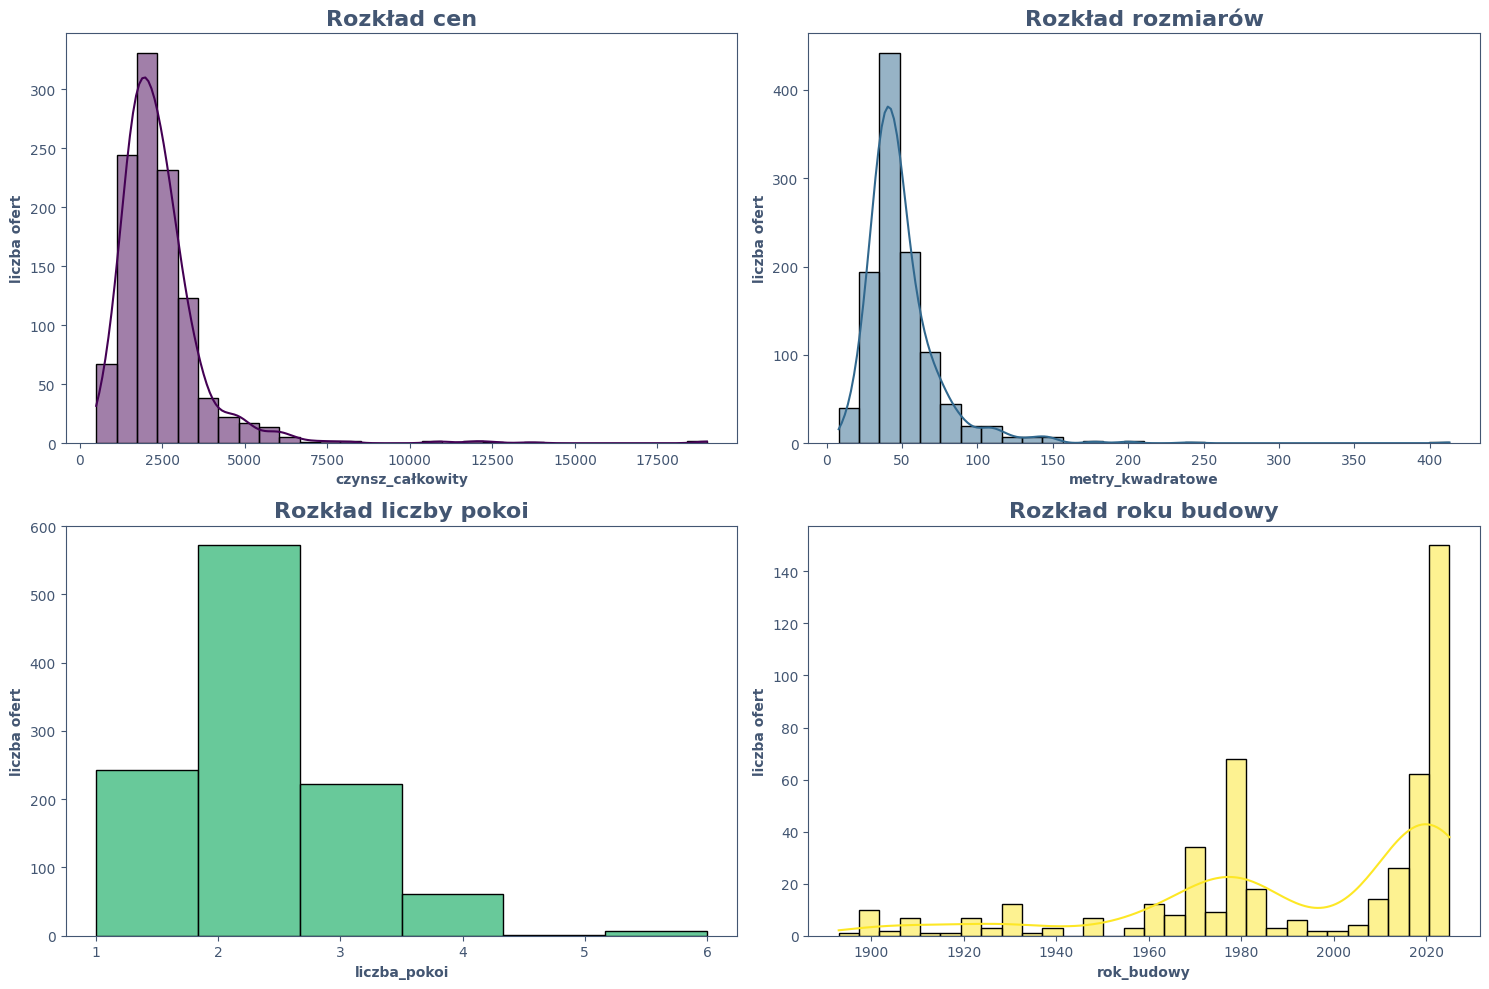

In [9]:
aesthetics_plots = {
	'title_size': 16,
    'y_and_x_label_size': 12,
	'fontweight': 'bold',
	'label_color': "#435672",
    "palette": "viridis",
    "figsize": {
        "multiplot": (15, 10),  # (width, height) in inches
        "singleplot": (8, 6),
        },
    }


def set_plot_aesthetics(
        ax: plt.Axes, 
        title: str, 
        title_fontsize: int = aesthetics_plots['title_size'], 
        color: str =aesthetics_plots['label_color'], 
        fontweight: str =aesthetics_plots['fontweight']
    ):


    ax.set_title(title, fontsize=title_fontsize, color=color, fontweight=fontweight)
    ax.set_xlabel(ax.get_xlabel(), fontweight=fontweight)
    ax.set_ylabel(ax.get_ylabel(), fontweight=fontweight)
    ax.tick_params(colors=color, which='both')  # For both major and minor ticks
    ax.yaxis.label.set_color(color)  # Y-axis label color
    ax.xaxis.label.set_color(color)  # X-axis label color
    for spine in ax.spines.values():  # Spine color
        spine.set_edgecolor(color)

def plot_distribution(combined_df: pd.DataFrame):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=aesthetics_plots['figsize']['multiplot'])

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 4))

    titles = ["Rozkład cen", "Rozkład rozmiarów", "Rozkład liczby pokoi", "Rozkład roku budowy"]
    data_columns = ['wycena.czynsz_całkowity', 'wielkość.metry_kwadratowe', 'wielkość.liczba_pokoi', 'rodzaj_i_rocznik.rok_budowy']
    kde_settings = [True, True, False, True]
    bins = [30, 30, 6, 30]

    for ax, title, color, data_column, kde_setting, bin in zip(axes.flat, titles, colors, data_columns, kde_settings, bins):
        sns.histplot(combined_df[data_column.split('.')[0]][data_column.split('.')[1]].astype('float'), ax=ax, kde=kde_setting, bins=bin, color=color)
        ax.set_ylabel("liczba ofert")
        set_plot_aesthetics(ax, title)

    plt.tight_layout()
    plt.show()

plot_distribution(combined_df)

**Insights Top Numerical Data:**

1. **Rental Prices**:<br>
Most rents are low, with a common amount around `2500`. There aren't many pricey places to rent.

1. **Apartment Sizes**:<br>
Smaller apartments are more common (around `50 m2`) than larger ones, with very few big apartments available.
Most have only `2` rooms extra besides the bathroom and kitchen or corridor.

1. **Building Ages**:<br>
A lot of buildings were put up around the year `1980`, and there's a recent surge in new ones in `2020`.<br>
You don't see many old buildings up for rent.

In [ ]:
def set_plot_aesthetics(ax, title=None, xlabel=None, ylabel=None, title_color="#435672", tick_color="#435672", fontweight='bold'):
    if title:
        ax.set_title(title, color=title_color, fontweight=fontweight)
    if xlabel:
        ax.set_xlabel(xlabel, fontweight=fontweight)
    if ylabel:
        ax.set_ylabel(ylabel, fontweight=fontweight)
    ax.tick_params(colors=tick_color, which='both')  # For both major and minor ticks
    ax.yaxis.label.set_color(tick_color)  # Y-axis label color
    ax.xaxis.label.set_color(tick_color)  # X-axis label color
    for spine in ax.spines.values():  # Spine color
        spine.set_edgecolor(tick_color)

def plot_distribution(combined_df: pd.DataFrame):

    # No information about furniture delete
    # refactor

    # Calculate medians
    median_furnished = combined_df[combined_df['equipment']['furniture']]['pricing']['total_rent'].median()
    median_unfurnished = combined_df[~combined_df['equipment']['furniture']]['pricing']['total_rent'].median()
    
    median_furnished_sqm = (combined_df[combined_df['equipment']['furniture']]['pricing']['total_rent_sqm']).median()
    median_unfurnished_sqm = (combined_df[~combined_df['equipment']['furniture']]['pricing']['total_rent_sqm']).median()

    # Prepare data for plotting
    median_data_furnishing = pd.DataFrame({
        'Furniture': ['Furnished', 'Unfurnished'],
        'Median Rent': [median_furnished, median_unfurnished]
    })

    median_data_square_meter = pd.DataFrame({
        'Furniture': ['Furnished', 'Unfurnished'],
        'Median Rent per Square Meter': [median_furnished_sqm, median_unfurnished_sqm]
    })

    title = 'Median Rent and Rent per Square Meter of Furnished\nvs\nUnfurnished Apartments'

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=aesthetics_plots['figsize']['multiplot'])

    # Plotting Median Rent
    sns.barplot(x='Furniture', y='Median Rent', data=median_data_furnishing, ax=ax1, palette='viridis')

    # Plotting Median Rent per Square Meter
    sns.barplot(x='Furniture', y='Median Rent per Square Meter', data=median_data_square_meter, ax=ax2, palette='viridis')

    for ax in [ax1, ax2]:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', fontsize=9, color=aesthetics_plots["label_color"], fontweight='bold',
                        xytext=(0, 5),
                        textcoords='offset points')
            
    # Apply aesthetics to each subplot
    set_plot_aesthetics(ax1, title='Median Rent', xlabel='Apartment Type', ylabel='Median Total Rent (PLN)')
    set_plot_aesthetics(ax2, title='Median Rent per Square Meter', xlabel='Apartment Type', ylabel='Median Total Rent per Meter (PLN)')

    # Set the main title for the figure
    fig.suptitle(title, color="#435672", fontsize=aesthetics_plots['title_size'], fontweight='bold')


    plt.tight_layout()
    plt.show()

    print(f"Median Differences:")
    print(f"Furnished vs Unfurnished: {abs(median_furnished - median_unfurnished)} PLN")
    print(f"Furnished vs Unfurnished per Square Meter: {(abs(median_furnished_sqm - median_unfurnished_sqm)).round()} PLN")

plot_distribution(combined_df)

**Insights Median Prices Furnishes vs Unfurnished:**

1. **Higher Median Rent for Furnished Apartments**:<br>
Furnished apartments have a higher median rent compared to unfurnished ones by 340 PLN.<br>
This suggests that renters pay a premium for the added convenience of a furnished space.

1. **Smaller Difference in Price per Square Meter**:<br>
When looking at the rent price per square meter,<br>
furnished apartments are only about 10 PLN more expensive than unfurnished ones.<br>
This smaller difference implies that the size of an apartment doesn't drastically affect the furnished rent premium.

In [ ]:
def show_categorical_data_percentage_distribution(
        df: pd.DataFrame, 
        categorical_column: Tuple[str, str], 
        distribution_column: Tuple[str, str], 
        title: str,
        x_ticks_number: int = 10,
        y_ticks_number: int = 8,
        x_ticks_rotation: bool = True,
        y_ticks_rotation: bool = True,
    ):
    
    # Create a subset DataFrame with only the required columns
    plot_data = df[[categorical_column, distribution_column]].dropna()

    # Set up the matplotlib figure
    plt.figure(figsize=(14, 7))

    # Get unique building types from the categorical column
    building_types = plot_data[categorical_column].unique()

    # Generate a list of colors, one for each building type
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"] + ['#51006f'] + ["#FF9F66"]

    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.

    # Plot each building type's histogram
    for building_type, color in zip(building_types, my_palette):
        # Select the rows where the building type matches and is not null
        subset = plot_data[plot_data[categorical_column] == building_type]
        sns.histplot(subset[distribution_column], kde=False, color=color, label=building_type, ax=ax)

    
    # Add some formatting and titles
    x_axis_title = distribution_column[1].replace('_', ' ')

    plt.title(title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
    plt.xlabel(x_axis_title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])
    plt.ylabel('Frequency', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])

    legend = plt.legend(title=x_axis_title)
    plt.setp(legend.get_title(), fontsize='large', color=aesthetics_plots['label_color'], weight='bold')
    plt.setp(legend.get_texts(), color=aesthetics_plots['label_color'])

    # Customize x-axis ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=x_ticks_number))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=y_ticks_number))

    if x_ticks_rotation:
        ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
    if y_ticks_rotation:
        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(ax.get_yticklabels(), rotation=45)

    plt.xticks(color=aesthetics_plots['label_color'])
    plt.yticks(color=aesthetics_plots['label_color'])
    
    sns.despine(right=True, top=True)

    # Add annotations for each bar
    for p in ax.patches:
        # Calculate the percentage of the total
        percentage = (p.get_height() / len(df)) * 100
        # Place the annotation above the bar
        if percentage > 0:
            ax.annotate(f"{percentage:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=10, color=aesthetics_plots['label_color'], xytext=(0, 8),
                        textcoords='offset points')

    # Show the plot
    plt.show()

In [ ]:
show_categorical_data_percentage_distribution(
    combined_df,  
    ('type_and_year', 'building_type'),
    ('pricing', 'total_rent'),
    'Distribution of Total Price for Each Building Type',
    x_ticks_number= 60,
    x_ticks_rotation= True
    )

**Insights from Distribution of Total Price for Each Building Type**:
1. `Apartment buildings` have a wide price distribution from `400` to `8000`, with a notable concentration between the range of `400` to `3.200`, most low budget-friendly offers in the data.

1. `Block of Flats`: Prices for blocks of flats show a slightly wider spread in the histogram, extending into the mid-price range (`800` to `3600`) and some outliers (`4800` to `5000`). The presence in both lower and mid-range pricing suggests a mix of both economical and upscale options for renters.

1. `Historic Apartment Buildings`: The distribution for historic apartment buildings tends to stretch across a broad range of prices (`400` to `3600`), with some properties listed at the higher end (`4000`, `5600`, `6000`, `8000`).

In [ ]:
show_categorical_data_percentage_distribution(
    combined_df,  
    ('type_and_year', 'building_type'),
    ('pricing', 'total_rent_sqm'),
    'Distribution of Total Price per Meter for Each Building Type',
    x_ticks_number= 40,
    x_ticks_rotation= True
    )

**Insights from Distribution of Total Price per Meter for Each Building Type**:

1. `The total price per meter` for `apartment buildings` is concentrated heavily around `50 PLN per sqm`.
1. `Historic apartment buildings` show a price per meter spread over a wider range, more in the lower end and high end (`8` to `128`) in the peak around `24`.
1. `Terraced houses`, while less common, show a consistently lower price per meter (`4` to `24`), suggesting higher space for a lower per meter price.

In [ ]:
def plot_distribution(combined_df: pd.DataFrame):

    # Calculation with handling of potential division by zero or NaN values
    plot_data = combined_df['pricing']['total_rent_sqm']
    plot_data = plot_data.dropna().round().astype('float')

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 4))
    color = colors[0]
    title = 'Distribution of Price per Square Meter'

    fig, ax = plt.subplots(figsize=aesthetics_plots['figsize']['singleplot'])
    hist = sns.histplot(plot_data, kde=True, bins=30, color=color, ax=ax)
    ax.set_xlabel('Price per Square Meter (PLN)')
    ax.set_ylabel('Frequency')

    for p in hist.patches:
        bin_center = p.get_x() + p.get_width() / 2
        ax.annotate(f'{bin_center:.1f}', (bin_center, p.get_height()), 
                    ha='center', va='center', fontsize=9, color=aesthetics_plots["label_color"], xytext=(0, 5),
                    textcoords='offset points')
        
    set_plot_aesthetics(ax, title)

    plt.tight_layout()
    plt.show()

plot_distribution(combined_df)

**Insights Price Per Square Meter:**

1. **Common Rent Prices**:<br>
Most apartments cost about `50 PLN` for each `square meter`.<br>
It's less common to find apartments that charge a lot more than this per square meter.

1. **Few Expensive Places**:<br>
The chart stretches out to the right, showing that while a few apartments have really high rent for each square meter,<br>
they're pretty rare. Most places stick close to the usual cost.

In [ ]:
CategoryResults = list[Tuple[str, str, float]]

def get_correlations(data: pd.DataFrame):
    
    def get_correlation_category(bottom_threshold: float, upper_threshold: float = 1.0):

        category_results: CategoryResults = []
        num_columns = len(columns)

        for i in range(num_columns):
            for j in range(i+1, num_columns):

                corr_value = correlations.iloc[i, j]
                col_left = columns[i]
                col_right = columns[j]

                category_results = add_correlation_value(
                        bottom_threshold, 
                        upper_threshold, 
                        category_results, 
                        corr_value, 
                        col_left, 
                        col_right
                    )
        
        sorted_results = sorted(category_results, key=lambda x: x[2], reverse=True)
        return sorted_results

    def add_correlation_value(
                bottom_threshold: float, 
                upper_threshold: float, 
                category_results: CategoryResults, 
                corr_value: float, 
                col_left: str, 
                col_right: str
            ):

        if upper_threshold == 1.0:
            if bottom_threshold <= abs(corr_value):
                category_results.append((col_left, col_right, corr_value))
        else:
            if bottom_threshold <= abs(corr_value) < upper_threshold:
                category_results.append((col_left, col_right, corr_value))

        return category_results
    
    correlations = data.corr()
    columns = correlations.columns
    correlations_results = {}
    
    correlations_results['Strong Correlations'] = get_correlation_category(bottom_threshold = 0.7)
    correlations_results['Moderate Correlations'] = get_correlation_category(bottom_threshold = 0.3, upper_threshold = 0.7)
    correlations_results['Weak Correlations'] = get_correlation_category(bottom_threshold = 0.1, upper_threshold = 0.3)

    return correlations_results

def print_results(correlations_results: dict[str, CategoryResults]):

    for level, results in correlations_results.items():
        print(f"\n{level}:")
        for col_left, col_right, corr_value in results:
            print(f"{col_left} - {col_right}: {round(corr_value, 2)}")
        print("\r")

def print_correlations(data: pd.DataFrame):
    
    correlations_results = get_correlations(data)
    
    print_results(correlations_results)

def get_top_extreme_results(correlations_results: dict[str, CategoryResults], column_of_interest: str, num_positive_negative: int):

    top_positive = []

    positive_count = 0

    for _, results in correlations_results.items():

        for col_left, col_right, corr_value in results:

            if corr_value > 0:

                correlation_cols = [col_left, col_right]

                if column_of_interest in correlation_cols:

                    if positive_count == num_positive_negative:
                        break

                    corr_item = (col_left, col_right, corr_value)

                    top_positive.append(corr_item)

                    positive_count += 1

        if positive_count == num_positive_negative:
            break

    top_negative = []

    negative_count = 0

    reversed_dict = dict(reversed(correlations_results.items()))

    for _, results in reversed_dict.items():

        for col_left, col_right, corr_value in results:

            if corr_value < 0:

                correlation_cols = [col_left, col_right]

                if column_of_interest in correlation_cols:

                    if negative_count == num_positive_negative:
                        break

                    corr_item = (col_left, col_right, corr_value)

                    top_negative.insert(0, corr_item)

                    negative_count += 1

        if negative_count == num_positive_negative:
            break

    top_positive.extend(top_negative)

    return top_positive

In [ ]:

def show_extreme_correlations(data: pd.DataFrame, column_of_interest: Tuple[str, str], num_results: int = 5, title: str = "Add title"):

    columns_to_drop = [('pricing', 'price'), ('pricing', 'rent')]
    data = data.drop(columns=columns_to_drop)
    correlations_results = get_correlations(data)
    extreme_correlations = get_top_extreme_results(correlations_results, column_of_interest, num_results)

    unique_elements = list(
        set([item[0] for item in extreme_correlations] + [item[1] for item in extreme_correlations])
    )
    correlation_values = np.zeros((len(unique_elements), len(unique_elements)))

    element_index_mapping = {
        element: index for index, element in enumerate(unique_elements)
    }

    for item in extreme_correlations:
        col1, col2, corr_value = item
        row_index = element_index_mapping[col2]
        col_index = element_index_mapping[col1]
        correlation_values[row_index, col_index] = corr_value

    df = pd.DataFrame(correlation_values, index=unique_elements, columns=unique_elements)
    df_column_of_interest = df[[column_of_interest]]
    df_no_empty_value = df_column_of_interest.drop(index=column_of_interest)
    df_no_0 = df_no_empty_value.drop(df_no_empty_value[df_no_empty_value.eq(0).all(axis=1)].index)
    df_plot = df_no_0.sort_values(by=column_of_interest, ascending=False)

    with plt.style.context('seaborn'):
        plt.figure(figsize=aesthetics_plots['figsize']['singleplot'])
        heatmap = sns.heatmap(df_plot, cmap='coolwarm', vmin = -1.0, vmax = 1.0, annot=True, fmt=".2f", annot_kws={'color': "white", 'fontweight': "bold"}, cbar=True, cbar_kws={"label": "Correlation"})
        # set color palette proportional to values 1.0 is always max 0.0 always least color value
        heatmap.set_xlabel("")
        heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, color=aesthetics_plots['label_color'])
        heatmap.set_xticklabels([])
        
        # Add the following lines
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([heatmap.collections[0].get_array().min(), heatmap.collections[0].get_array().max()])
        cbar.set_ticks([-1.0, 0, 1.0])  # Set the tick locations
        cbar.set_ticklabels(['-1.0', '0.0', '1.0'])  # Set the tick labelss
        cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color=aesthetics_plots['label_color'])  # Set the tick label color
        cbar.set_label("Correlation", color=aesthetics_plots['label_color'])
        
        plt.title(f'Correlation: {title}\n', color=aesthetics_plots['label_color'], fontsize = aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
        plt.show()


In [ ]:
show_extreme_correlations(combined_df, ('pricing', 'total_rent'), num_results = 10, title="Total Price")

**Insights Total Price Correlations:**

1. **Deposit and Total Price**:<br>
There is a strong positive relationship between the deposit amount and the total price, indicated by a correlation of `0.86`.<br>
This suggests that higher-priced rentals typically require a higher deposit.

1. **Size Matters**:<br>
The apartment size, measured in square meters, has a significant positive correlation `(0.54)` with the total price,<br>
meaning larger apartments tend to be more expensive.<br>
The number of rooms also shows a positive correlation `(0.46)` with price, though it's not as strong as the size in square meters,<br>indicating that the overall size may be more influential on price than the mere number of rooms.

1. **Features and Lack of Information**:<br>
Additional features like air conditioning have a moderate positive correlation `(0.38)` with total price,<br>
implying that apartments with air conditioning might be priced higher.<br>
Interestingly, there's a slight negative correlation `(-0.15)` with 'no information' provided in media types,<br>
which could suggest that listings with less information may be associated with slightly lower prices,<br>
or it might indicate a trend where less expensive listings provide fewer details.

Other correlations:

In [ ]:
print_correlations(combined_df)

**Insights Other Correlations:**

1. **Price Consistency**:<br>
The almost perfect correlation `(0.98)` between `'pricing`' and `'price'` vs. `'total_rent'` suggests that the rent price consistently contributes to the total cost of renting, likely inclusive of additional fees or services.

1. **Equipment Bundling**:<br>
The strong correlations among various pieces of equipment (stove, fridge, washing machine, oven) ranging from `0.78` to `0.89` indicate that these are often bundled together in rental properties. If a rental has one of these appliances, it's very likely to have the others.

1. **Safety and Convenience Features**:<br>
There is a moderate positive correlation (`0.68` to `0.64`) between having certain appliances (stove, fridge, washing machine) and security features like intercom or video intercom systems. This could imply that properties equipped with modern conveniences also prioritize security.

### 2.3 Location

In [ ]:
def count_and_percentage_with_distance(df, column_name, city_coords, city_populations):

    # Flatten the index to avoid groupby issues
    df_temp = pd.DataFrame()
    df_temp[str(column_name)] = df[column_name]
    column_name = str(column_name)
    df_temp['median_price (PLN)'] = df[('pricing', 'total_rent')]
    df_temp['square_meters'] = df[('size', 'square_meters')]
    df_temp['median_total_rent_sqm (PLN)'] = df[('pricing', 'total_rent_sqm')]

    if column_name not in df_temp.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    # Calculate count and percentage
    count = df_temp[column_name].value_counts(dropna=False)
    percentage = df_temp[column_name].value_counts(dropna=False, normalize=True) * 100

    # Create a DataFrame from the count and percentage
    result = pd.DataFrame({
        'Count': count,
        'Percentage': percentage
    }).reset_index()

    # Rename the 'index' column to the actual column name for clarity
    result.rename(columns={'index': column_name}, inplace=True)

    # Add median ('pricing', 'total_rent')
    grouped = df_temp.groupby(column_name)
    median_rent = grouped['median_price (PLN)'].median()
    median_sqm = grouped['square_meters'].median()
    median_sqm_rent = grouped['median_total_rent_sqm (PLN)'].median()

    result = result.join(median_rent, on=column_name)
    result = result.join(median_sqm, on=column_name)
    result = result.join(median_sqm_rent, on=column_name)

    # Calculate the distance from the central city for each city
    central_city = 'Mierzęcice, Będziński, Śląskie'
    central_city_coords = city_coords['central_city'][central_city]
    
    result[f'Distance from {central_city} (km)'] = result.apply(
        lambda row: round(haversine(central_city_coords, city_coords['distance_from_central_city'].get(row[column_name], (None, None)), unit='km'), 2)
        if row[column_name] in city_coords['distance_from_central_city'] else None, axis=1)

    # Add city population information
    result['City Population (Thousands)'] = result[column_name].map(city_populations)

    return result

In [ ]:
city_populations = {
    "Katowice": 286,
    "Sosnowiec": 191,
    "Bytom": 161,
    "Dąbrowa Górnicza": 116,
    "Chorzów": 105,
    "Jaworzno": 89,
    "tarnogórski": 45, # Rular area
    "będziński": 38, # Rular area
    "Siemianowice Śląskie": 65,
    "Mysłowice": 72,
    "Piekary Śląskie": 54,
    "Świętochłowice": 49,
    "Ruda Śląska": 135,
    "myszkowski": 32, # Rular area
    "częstochowski": 119, # Rular area
    "zawierciański": 43,  # Rular area
    "Zawada": 0.16  # Rular area
}

city_coords = {
    "central_city": {
        "Mierzęcice, Będziński, Śląskie": (50.4441, 19.12405)
    },
    "distance_from_central_city": {
        "Katowice": (50.258598, 19.020420),
        "Sosnowiec": (50.286263, 19.104078),
        "Bytom": (50.348160, 18.917561),
        "Dąbrowa Górnicza": (50.325910, 19.187200),
        "Chorzów": (50.297642, 18.955420),
        "Jaworzno": (50.203439, 19.272156),
        "tarnogórski": (50.444241, 18.856491),
        "będziński": (50.415352, 19.11304),
        "Siemianowice Śląskie": (50.30563, 19.028088),
        "Mysłowice": (50.209621, 19.132166),
        "Piekary Śląskie": (50.375779, 18.937939),
        "Świętochłowice": (50.298945, 18.907466),
        "Ruda Śląska": (50.270348, 18.864388),
        "myszkowski": (50.605529, 19.294746),
        "częstochowski": (50.7979, 19.1247),
        "zawierciański": (50.54427, 19.619602),
        "Zawada": (50.43734, 19.096938),
    }
}

locations_summary = count_and_percentage_with_distance(combined_df, ("location", "city"), city_coords, city_populations)
locations_summary

In [ ]:
locations_summary[["('location', 'city')", "median_price (PLN)", "median_total_rent_sqm (PLN)"]].sort_values(by="median_total_rent_sqm (PLN)", ascending=False)

**Insights Location and Price**:

1. Higher Rents in Larger Cities: Katowice, the largest city with `286,000 people`, leads in both the number of listings `(514)` and rent prices. It has a median rent of `2600 PLN` and a price of `57.78 PLN` per square meter. This shows that in bigger cities like Katowice, living costs, including rent, are generally higher.

1. Rent Increases with City Size: In larger cities, rent tends to be pricier. For example, `Katowice` and `Sosnowiec`, with larger populations, have median rents of `2600 PLN` and `2000 PLN`, respectively. In contrast, smaller areas like `Zawiercie` and `Myszkowski` have significantly lower rents.

1. Location's Influence on Rent: The distance from `Mierzęcice`, `Będziński, Śląskie` impacts rent. Closer locations like `Będziński` (`3.29 km` away) have a lower price per square meter (`44.66 PLN`) compared to further cities like `Jaworzno` (`28.75 km` away) with `45.01 PLN` per square meter. This indicates that proximity to a central point can influence rental prices.

In [ ]:
geolocator = Nominatim(user_agent="your_app_name")

def get_coordinates(address, attempt=1, max_attempts=3):
    try:
        location = geolocator.geocode(address, timeout=10)  # Increase timeout to 10 seconds
        if location:
            return (location.latitude, location.longitude)
        else:
            return (None, None)
    except GeocoderTimedOut:
        if attempt <= max_attempts:
            time.sleep(1 * attempt)  # Exponential backoff
            return get_coordinates(address, attempt + 1, max_attempts)
        return (None, None)
    except GeocoderUnavailable:
        return (None, None)

def add_geo_data_to_offers(df: pd.DataFrame):

    df_temp = pd.DataFrame()
    df_temp['complete_address'] = df[('location', 'complete_address')]
    df_temp['city'] = df[('location', 'city')] + ", " + df[('location', 'voivodeship')]
    df_temp['price_total'] = df[('pricing', 'total_rent')]
    df_temp['price'] = df[('pricing', 'price')]
    df_temp['rent'] = df[('pricing', 'rent')]
    df_temp['rent_sqm'] = df[('pricing', 'total_rent_sqm')]
    df_temp['sqm'] = df[('size', 'square_meters')]
    df_temp['is_furnished'] = df[('equipment', 'furniture')]

    # Create unique address list
    unique_addresses = df[('location', 'complete_address')].unique()
    address_coords = {}

    for address in unique_addresses:
        coords = get_coordinates(address)
        if coords == (None, None):
            # If coordinates for the complete address are not found, try with city
            city = df_temp[df_temp['complete_address'] == address]['city'].values[0]
            coords = get_coordinates(city)
        address_coords[address] = coords

    # Map the coordinates back to the DataFrame
    df_temp['coords'] = df_temp['complete_address'].map(address_coords)

    return df_temp

# map_df = add_geo_data_to_offers(combined_df) # Takes a while to run due to server requests latency
# data_path_manager.save_df(map_df, "map")

In [ ]:
map_df = data_path_manager.load_df("map", is_cleaned=True)

In [ ]:
print("Unique geo coordinates:")
len(map_df['coords'].unique())

In [ ]:
def show_property_map(
        map_df: pd.DataFrame, title: str = "", 
        center_coords: tuple[float, float] = None, 
        center_marker_name: str = "Mierzęcice, Będziński, Śląskie", 
        zoom: float = 10.0
        ):
    
    def extract_lat_lon(coord):
        coord_parts = coord.strip('()').split(', ')
        coord_tuple = tuple(float(part) if part.strip() != "None" else None for part in coord_parts)
        return coord_tuple

    def create_heatmap_data(plot_data: pd.DataFrame) -> go.Figure:
        
        def get_hovertemplate(row):

            labels = ["City:", "Complete Address:", "Total Price:", "Price:", "Rent:", "Square Meters:", "Price/Sqm:", "Furnished:"]
            max_label_length = max(len(label) for label in labels)
            font_style = "font-family:monospace;"

            return (
                f"<span style='{font_style}'>{'City:'.ljust(max_label_length)}</span> {row['city']}<br>"
                f"<span style='{font_style}'>{'Street:'.ljust(max_label_length)}</span> {row['complete_address'].replace((', ' + row['city']), '') if row['city'] else row['complete_address']}<br>"
                f"<span style='{font_style}'>{'Total Price:'.ljust(max_label_length)}</span> {row['price_total']}<br>"
                f"<span style='{font_style}'>{'Price:'.ljust(max_label_length)}</span> {row['price']}<br>"
                f"<span style='{font_style}'>{'Rent:'.ljust(max_label_length)}</span> {row['rent']}<br>"
                f"<span style='{font_style}'>{'Square Meters:'.ljust(max_label_length)}</span> {row['sqm']}<br>"
                f"<span style='{font_style}'>{'Price/Sqm:'.ljust(max_label_length)}</span> {row['rent_sqm']}<br>"
                f"<span style='{font_style}'>{'Furnished:'.ljust(max_label_length)}</span> {row['is_furnished']}<extra></extra>"
            )

        offer_counts = plot_data.groupby(['Latitude', 'Longitude']).size().reset_index(name='offer_count')
        plot_data = plot_data.merge(offer_counts, on=['Latitude', 'Longitude'])

        plot_data['hovertemplate'] = plot_data.apply(get_hovertemplate, axis=1)

        return go.Densitymapbox(
            lat=plot_data['Latitude'],
            lon=plot_data['Longitude'],
            z=plot_data['offer_count'],  # Use offer count as density
            radius=10,
            colorscale='Viridis',
            zmin=0,
            zmax=plot_data['offer_count'].max(),  # Maximum count of offers
            hovertemplate=plot_data['hovertemplate'],
            colorbar=dict(
                title='Number<br>of<br>offers:',
            )
        )

    def update_fig(fig: go.Figure, mapbox_zoom: float, mapbox_center: dict):
        fig.update_layout(
            title_text=title,
            mapbox_style='carto-positron',
            mapbox_zoom=mapbox_zoom,
            mapbox_center=mapbox_center,
            margin=dict(l=0, r=0, t=40, b=0),
            coloraxis_colorbar=dict(
                title="Number<br>of<br>offers:",
                title_side='right',
                title_font=dict(size=20),
                y=-2,
                yanchor='middle'
            )
        )
        return fig
    
    map_df['rent_sqm'] = map_df['rent_sqm'].round(2)
    
    lat_lon = map_df['coords'].apply(extract_lat_lon)
    map_df['Latitude'], map_df['Longitude'] = zip(*lat_lon)

    heatmap = create_heatmap_data(map_df)
    fig = go.Figure(data=[heatmap])

    # Determine the center of the map
    if center_coords is None:
        center_coords = {"lat": map_df['Latitude'].mean(), "lon": map_df['Longitude'].mean()}
    else:
        center_coords = {"lat": center_coords[0], "lon": center_coords[1]}
        # Add a pin (marker) at the center coordinates
        fig.add_trace(go.Scattermapbox(
            lat=[center_coords['lat']],
            lon=[center_coords['lon']],
            mode='markers+text',  # Include 'text' in the mode
            marker=go.scattermapbox.Marker(
                size=10,
                color='red'
            ),
            text=[center_marker_name],  # Set the label text
            textposition="bottom right",  # Position the text
            showlegend=False,
        ))

    fig = update_fig(fig, mapbox_center=center_coords, mapbox_zoom=zoom)
    fig.show()

# Example usage
show_property_map(map_df, "Property Prices Heatmap", center_coords=(50.460740, 19.093210), center_marker_name = "Mierzęcice, Będziński, Śląskie", zoom=9)

### 2.4 Attributes and equipment

In [ ]:
def display_category_proportions(data: pd.Series, title: str):
    # Check if data is a Series and of string type
    if not isinstance(data, pd.Series) or data.dtype != 'string[python]':
        raise TypeError("Data must be a pandas Series with string type.")

    # Calculate the percentage of each category
    category_percentage = data.value_counts(normalize=True) * 100

    # Create a bar plot
    fig, ax = plt.subplots(figsize=aesthetics_plots["figsize"]["multiplot"])
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"] + ['#51006f']*2

    unique_categories = data.unique()
    length = len(unique_categories)
    if (length - 5) <= 0:
        adjusted_length = 1
    else:
        adjusted_length = length - 5
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"]*2 + ['#51006f']*adjusted_length

    # Make the index more readable
    more_readable_index = []
    for _index in category_percentage.index:
        more_readable_index.append(_index.replace('_', ' '))
    category_percentage.index = more_readable_index

    sns.barplot(x=category_percentage.index, y=category_percentage.values, ax=ax, palette=my_palette)
    
    # Add labels to the plot
    plt.title(title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
    plt.xlabel('Category', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])
    plt.ylabel('Percentage (%)', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])

    plt.xticks(color=aesthetics_plots['label_color'])
    plt.yticks(color=aesthetics_plots['label_color'])
    
    sns.despine(right=True, top=True)


    # Add percentage labels on the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color=aesthetics_plots['label_color'], xytext=(0, 5),
                    textcoords='offset points')

    # Display the plot
    plt.show()


display_category_proportions(combined_df[('type_and_year', 'building_type')], "Category Percentage Distribution")

In [ ]:
show_categorical_data_percentage_distribution(
    combined_df,  
    ('type_and_year', 'building_type'),
    ('type_and_year', 'build_year'),
    'Distribution of Build Years for Each Building Type'
    )

**Building Type and Build Year Insights**:
1. "Block of flats," comprising `48.2%` of the dataset, is the predominant category, indicating a strong preference for `apartment` living offers. This choice is common in both `historical urban` areas, and the later era often characterized by "large panel system-building" from communist times, and in newer developments, showing a consistent demand for this type of housing throughout different eras.

1. The notable increase in construction after the year `2000` points to a rise in the availability of newer residences. However, `terraced houses` and `detached houses` make up only `0.3%` and `2.8%` of the housing types, respectively, signifying their rare occurrence in recent urban development. This scarcity suggests an urban development trend that favors multi-story buildings over individual houses, indicating a preference for vertical expansion in housing developments.

In [ ]:
def move_index_to_last(series, index_to_move):
    """
    Moves a specified index to the last position in a pandas Series.

    Args:
    series (pd.Series): The original series.
    index_to_move (str): The index to be moved to the last position.

    Returns:
    pd.Series: A new series with the specified index moved to the last position.
    """
    if index_to_move not in series.index:
        raise ValueError(f"Index '{index_to_move}' not found in the Series.")

    # Extracting the indices
    idx_list = series.index.tolist()

    # Remove the index to move and then append it at the end
    idx_list.remove(index_to_move)
    idx_list.append(index_to_move)

    # Reindexing the series
    return series.reindex(idx_list)

In [ ]:
def visualize_true_percentage_by_category(df: pd.DataFrame, main_category: str):
    # Check if the DataFrame contains the main category
    if main_category not in df.columns.get_level_values(0):
        raise KeyError(f"Main category '{main_category}' not found in DataFrame.")

    # Extract subcategories for the given main category
    subcategories = [col for col in df.columns if col[0] == main_category]

    # Calculate percentage of True values for each subcategory
    percentages = {}
    for subcat in subcategories:
        percentages[subcat[1]] = (df[subcat].sum() / len(df)) * 100

    # Convert to Series for plotting
    category_percentage = pd.Series(percentages)

    # Sort by percentage, 'no_information' should be last
    category_percentage = category_percentage.sort_values(ascending=False)
    if 'no_information' in category_percentage.index:
        category_percentage = move_index_to_last(category_percentage, 'no_information')

    # Create a bar plot
    if category_percentage.index.__len__() >= 5:
        plot_size = aesthetics_plots["figsize"]["multiplot"]
    else:
        plot_size = aesthetics_plots["figsize"]["singleplot"]

    fig, ax = plt.subplots(figsize=plot_size)

    # Set the palette
    length = len(category_percentage.index)
    if (length - 5) <= 0:
        adjusted_length = 1
    else:
        adjusted_length = length - 5
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"]*2 + ['#51006f']*adjusted_length

    if 'no_information' in category_percentage.index:
        my_palette = my_palette[:max(1, length - 1)] + ['#b3b3b3']

    more_readable_index = []
    for _index in category_percentage.index:
        more_readable_index.append(_index.replace('_', '\n'))

    category_percentage.index = more_readable_index

    sns.barplot(x=category_percentage.index, y=category_percentage.values, ax=ax, palette=my_palette)
    
    # Add labels to the plot
    title = "Percentage in " + main_category.replace('_', ' ').title()
    plt.title(title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
    plt.xlabel('Category', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])
    plt.ylabel('Percentage of True (%)', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])

    plt.xticks(color=aesthetics_plots['label_color'])
    plt.yticks(color=aesthetics_plots['label_color'])
    
    sns.despine(right=True, top=True)

    # Add percentage labels on the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color=aesthetics_plots['label_color'], xytext=(0, 5),
                    textcoords='offset points')

    # Display the plot
    plt.show()

visualize_true_percentage_by_category(combined_df, 'amenities')

**Amenities Insigts**:
1. `Elevators` are included in `36.5%` of the apartment offers.
1. `Parking spaces` are available in `31.6%` of the listings.

In [ ]:
visualize_true_percentage_by_category(combined_df, 'equipment')

**Equipment Plot Insights**:

1. `Furniture` is included in `65.8%` of the apartments, while `fridges` and `stoves` are present in `54%` and `52.3%` of the units, respectively, and `washing machines` are found in exactly `half` of the offerings. This demonstrates a tendency for apartments to be equipped with essential appliances for tenants seeking ready-to-move-in properties.
1. The presence of `TVs` in `25.1%` and `dishwashers` in `31.7%` of the offers shows these are less common, possibly due to being considered non-essential.

In [ ]:
visualize_true_percentage_by_category(combined_df, 'media_types')

**Media Types Plot Insights**:
1. `Internet access` is mentioned in `40.9%` of the listings and, `32.0%` for the `cable tv`.
1. `No information` about media types is reported in `56.8%` of the offers, showing that for most it's irrelevant information.

In [ ]:
visualize_true_percentage_by_category(combined_df, 'heating')

**Heating Plot Insights**:

1. `District heating` is the most reported type at `61.6%`, reflecting its widespread use in urban settings or apartment complexes.
1. The `gas` `11.3%` and especially `electric` `3.6%` heating is low due to high costs.

In [ ]:
visualize_true_percentage_by_category(combined_df, 'security')

**Security Plot Insights**:

1. `Intercom` or `video intercom` systems are noted in `51.2%` of the offers, quite common feature.
1. More advanced security features like `alarm systems` are mentioned in only `2.6%` of the listings, and `anti-burglary roller blinds` in `3.0%`, suggesting that these may be less common or highlighted only in premium offerings.

In [ ]:
visualize_true_percentage_by_category(combined_df, 'windows')

**Windows Plot Insights**:

1. `Plastic` windows dominate the features at `71.5%`.
1. There is a notable `lack of information` in `25.8%` of listings regarding window types.

In [ ]:
visualize_true_percentage_by_category(combined_df, 'building_material')

**Building Material Plot Insights**:

1. `Brick` is specified in `25.2%` of the properties, possibly due to its desirable qualities such as durability and insulation.
1. `large panel` is mentioned in `10.8%`, but the result could be undermined by not mentioning it due to unpopularity among prospective tenants.
1. Almost half of the listings, at `49.6%`, do `not disclose` building material.

In [ ]:
visualize_true_percentage_by_category(combined_df, 'additional_information')

**Additional Information Plot Insights**:
1. `Separate kitchens` and `basements` are prominent features in the apartment offerings, with `30.0%` and `28.4%` of listings advertising these `amenities`, respectively. A clearly defined cooking spaces and additional storage or living areas represented by basements.

1. A smaller but notable percentage of listings specify `non-smokers only` `(13.9%)` and include a `utility room` `(12.8%)`.

1. `Air conditioning` and `duplex configurations` are rare, at `8.7%` and `0.6%` respectively, which may imply that these features are non-standard. The overwhelming of listings `(39.4%)` `do not provide additional information`.